(Temporary) upload file in Colab then specify path and filename

In [3]:
!mkdir input
!mkdir output

url, filename = ("/content/input/bankst.jpg", "bankst.png") # IMAGE MUST BE JPG

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘output’: File exists


# Setup

In [4]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00


In [5]:
import cv2
import torch
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [6]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:23<00:00, 59.5MB/s]


Move model to GPU if available

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

Load transforms to resize and normalize the image for large or small model

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [44]:
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Image as a numpy ndarray
input_batch = transform(img).to(device)

(679, 1242, 3)


Predict and resize to original resolution

In [10]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

(679, 1242)

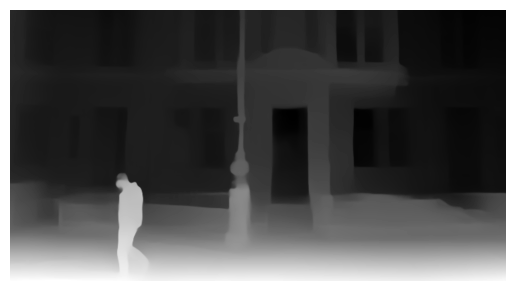

In [11]:
plt.imshow(output, cmap='gray')
plt.axis('off')
output.shape

# Image segmentation
Set up image segmentation

In [12]:
!pip install transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import cm

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


(…)ic/resolve/main/preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

(…)e-coco-panoptic/resolve/main/config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

Reshape and normalise depth map (currently redundant)

In [13]:
output_reshape = np.dstack((output, output, output)) # Convert to image with 3 dimensions
output_reshape = (output_reshape-np.min(output_reshape))/(np.max(output_reshape)-np.min(output_reshape))

Predict image segments

In [14]:
img_pil = Image.open(url)

inputs = processor(img_pil, return_tensors='pt')

with torch.no_grad():
  outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img_pil.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Display image segments

<ipython-input-15-48b15c2a5c09>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


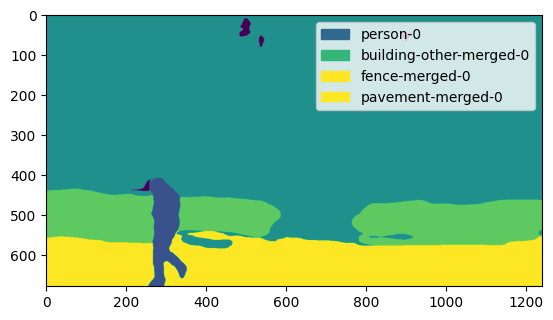

In [15]:
from collections import defaultdict
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)
draw_panoptic_segmentation(prediction['segmentation'], prediction['segments_info'])

Take each segment and create a mask

In [16]:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb

def get_mask(segment_id):
  mask = (prediction['segmentation'].numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

Create a dictionary with value PIL image of mask and corresponding depth value pair

In [17]:
mask_info = {}

def mask_generator():
    for segment_info in prediction['segments_info']:
        mask_pil = get_mask(segment_info['id'])
        median_value = np.median(output[np.array(mask_pil)])
        yield mask_pil, median_value

for i, (mask_pil, median_depth) in enumerate(mask_generator()):
  mask_info[i] = [mask_pil, median_depth]

Sort the dictionary by depth ascending

In [18]:
mask_info = dict(sorted(mask_info.items(), key=lambda item: item[1][1]))

for mask in mask_info:
  print(mask_info[mask][1])

7.9246554
7.969194
7.9791064
7.984064


Reindex the dictionary according to the ascending depth

In [19]:
def reindex_dict(mask_info):
  i = 0
  new_dict = {}
  for mask in mask_info:
    new_dict[i] = mask_info[mask]
    i+=1
  return new_dict

mask_info = reindex_dict(mask_info)

Create depth ranges to chop image into

In [20]:
depth_ranges = [[mask_info[i][1], mask_info[i+1][1]] for i in range(len(mask_info)-1)]
print(depth_ranges)

[[7.9246554, 7.969194], [7.969194, 7.9791064], [7.9791064, 7.984064]]


Chop the image into different depth levels

In [73]:
depth_planes = []
for (a,b) in depth_ranges:
  depth_image = np.zeros_like(output.shape)
  for m in mask_info:
    if a <= mask_info[m][1] <= b:
      mask_reshape = np.stack((mask_info[m][0], mask_info[m][0], mask_info[m][0]), axis=-1)
      depth_planes.append(np.where(mask_reshape, img, mask_reshape))

## Now we move to the inpainting pipeline

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [ ]:
import inspect
from typing import List, Optional, Union
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

In [ ]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


mask = Image.fromarray(mask)

.### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}